In [25]:
import numpy as np
import torch


import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
from seaborn import kdeplot

In [637]:
def leapfrog(A, x0, v0, stepsize=1, n_steps=10):
    '''
    Solves ODE of the form (d^2 x)/ (d t^2) = A(x)
    using leapfrog iterations (https://en.wikipedia.org/wiki/Leapfrog_integration)

    Parameters:
    
    A : function
        Acceleration function R^p -> R^p. Takes position vector x and 
        returns acceleration: a = A(x).
    x0 : array
        Initial condition for position.
    v0 : array 
        Initial condition for velocity.
    stepsize : number
        Stepsize, default = 1.
    n_steps : int
        Number of steps, default = 10.
    '''
    dt = stepsize ## alias
    a0 = A(x0)
    v = v0 - a0 * dt/2 ## backward 1/2 step
    x = x0
    for i in range(n_steps):
        a = A(x)
        v = v + a * dt
        x = x + v * dt
        yield x, v




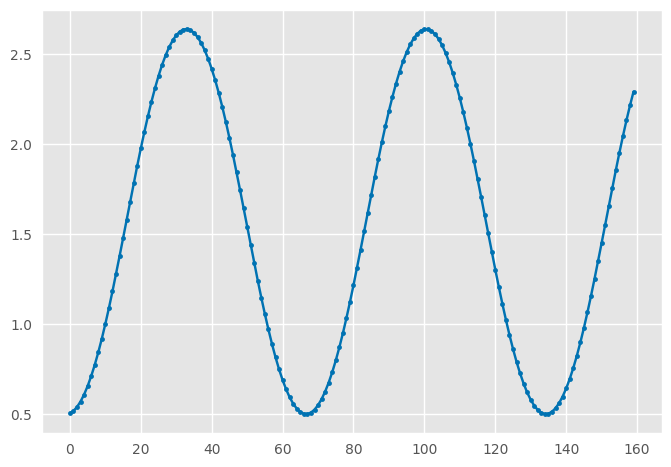

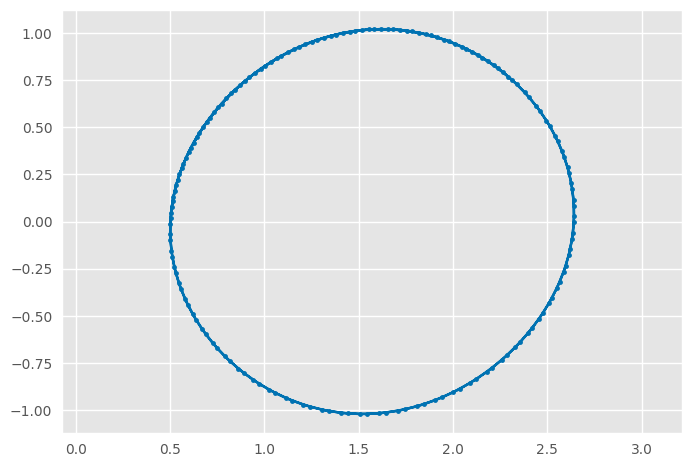

In [638]:
A = lambda x:np.cos(x)
x0, t0 = 0.5,0

states = leapfrog(A, x0, t0, stepsize=0.1, n_steps=160)

## Option 1: take the entire trajectory
states = np.array(list(states))
## Option 2: take only the final solution
*_, final = states


plt.plot(states[:,0], '.-')
plt.show()
plt.plot(states[:,0], states[:,1], '.-')
plt.axis('equal')
plt.show()

In [639]:
def HMC(U, theta0, std=1, stepsize=0.01, n_steps=10, n_samples=10):
    '''
    Hamiltonian Monte Carlo
    
    Parameters:
    
    U : function
        Potential energy function U(theta). 
        Differentiable w.r.t theta, through U(theta).backward()
    theta0 : PyTorch tensor
        Initial condition
    std : number
        sqrt(mass), used as std of Gaussian
    stepsize : number
    '''
    
    def neg_dU(theta):
        '''negative gradient of dU through autodiff'''
        theta = theta.detach().clone().requires_grad_(True)
        if theta.grad is not None:
            theta.grad.fill_(0)
        u = U(theta)
        u.backward()
        return -theta.grad

    def H(theta, r):
        '''Hamiltonian function'''
        return U(theta) + 1/2 * (r**2).sum()
        
    theta = theta0
    for t in range(n_samples):
        rt = torch.randn(1) * std
        states = leapfrog(neg_dU, theta, rt, stepsize, n_steps)
        states = list(states)
        *_, proposal = states
        
        ## TODO: Metropolis-Hastings correction
        u = torch.rand(1)
        p = torch.exp(
            H(proposal[0], proposal[1]) 
            - H(theta, rt)
        )
        if u < min(1, p):
            theta = proposal[0]
            sample = proposal
        else:
            sample = [theta, rt]
            
        yield dict(
            states = states,
            sample = sample
        )

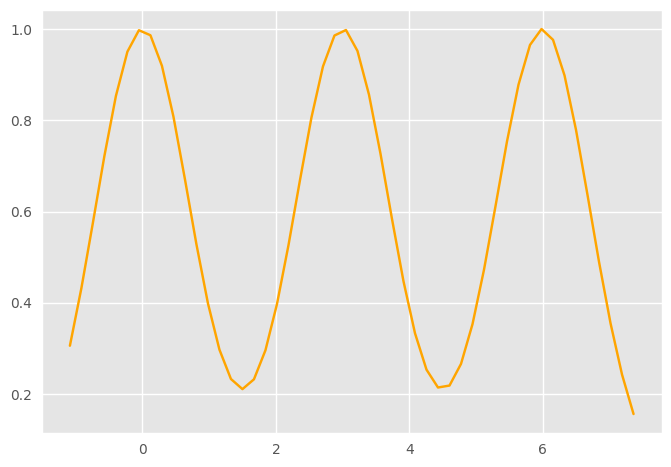

In [640]:
plt.plot(x, torch.exp(-U(x)), color='orange', zorder=3)

(-3.1828259587287904,
 9.329507505893707,
 -3.7028831362724306,
 3.4049912810325624)

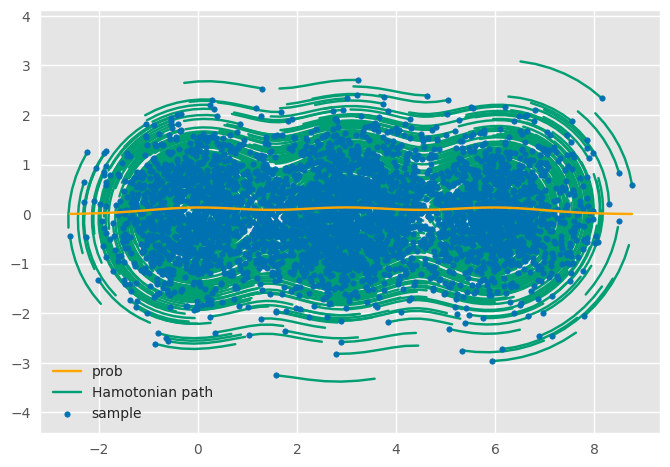

In [671]:
U = lambda x: -torch.log(
    (torch.exp(-x**2/2) + torch.exp(-(x-3)**2 / 2) + torch.exp(-(x-6)**2/2) )/3/np.sqrt(2*np.pi)
)
x0 = torch.tensor(0.01)

results = HMC(U, x0, std=0.8, stepsize=0.1, n_steps=7, n_samples = 4000)
results = list(results)
samples = torch.tensor([r['sample'] for r in results])
states = torch.tensor([r['states'] for r in results])

xmin = samples[:,0].min()
xmax = samples[:,0].max()
x = torch.linspace(xmin, xmax, 50)
plt.plot(x, torch.exp(-U(x)), color='orange', zorder=3, label='prob')
for i in range(states.shape[0]):
    plt.plot(states[i,:,0], states[i,:,1], 'C1-', label='Hamotonian path' if i==0 else None)
plt.scatter(samples[:,0], samples[:,1], zorder=2, s=15, label='sample')
plt.legend()
plt.axis('equal')

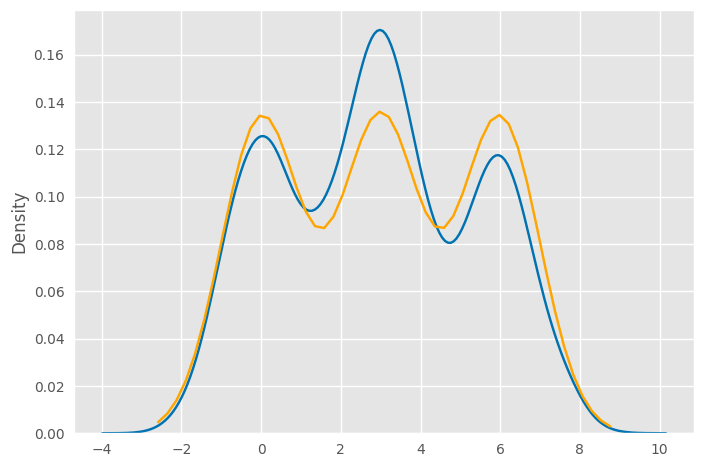

In [673]:
# plt.plot(samples[:,0],samples[:,1], '.-')
# plt.scatter(samples[:,0],samples[:,1])
# plt.hist(samples[:,0].numpy(), bins=30);
kdeplot(samples[:,0].numpy())
y = torch.exp(-U(x))
plt.plot(x, y, color='orange', zorder=3)
